In [2]:
import requests
from bs4 import BeautifulSoup
import html
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def obsahuje_klucove_slova(nazov_pozicie):
    klucove_slova = ['anal', 'data', 'python', 'vedec']
    return any(klucove_slovo in nazov_pozicie.lower() for klucove_slovo in klucove_slova)

def ocisti_a_rozdel_plat(platny_rozsah_text):
    ocisteny_plat = ''.join(c for c in str(platny_rozsah_text) if c.isdigit())
    if len(ocisteny_plat) == 10:
        return int(ocisteny_plat[:5]), int(ocisteny_plat[5:])
    elif len(ocisteny_plat) == 12: 
        return int(ocisteny_plat[:6]), int(ocisteny_plat[6:])
    elif len(ocisteny_plat) == 11: 
        return int(ocisteny_plat[:5]), int(ocisteny_plat[5:])
    else:
        return int(ocisteny_plat), 0

def ziskaj_platy(zakladna_url, rozsah_stran):
    hlavicky = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    platy_zoznam = []

    for cislo_strany in range(1, rozsah_stran + 1):  # Zaƒçnite od strany 1
        aktualna_url = f"{zakladna_url}&page={cislo_strany}"

        odpoved = requests.get(aktualna_url, headers=hlavicky)

        if odpoved.status_code == 200:
            pole = BeautifulSoup(odpoved.text, 'html.parser')
            pracovne_inzeraty = pole.select('article')

            for pracovny_inzerat in pracovne_inzeraty:
                odkaz_pozicie = pracovny_inzerat.select_one('header h2 a')
                if not odkaz_pozicie:
                    continue

                nazov_pozicie = odkaz_pozicie.get_text(strip=True)
                odkaz_prace = odkaz_pozicie['href']

                if not obsahuje_klucove_slova(nazov_pozicie):
                    print(f"Ignorovanie pr√°ce - Poz√≠cia: {nazov_pozicie} (Neobsahuje relevantn√© kƒæ√∫ƒçov√© slov√°)")
                    continue

                znacka_platu = pracovny_inzerat.select_one('div span.Tag.Tag--success.Tag--small.Tag--subtle')
                if znacka_platu:
                    text_rozsahu_platu = znacka_platu.get_text(strip=True)
                    dekodovany_rozsah_platu = html.unescape(text_rozsahu_platu)
                    ocisteny_plat = ocisti_a_rozdel_plat(dekodovany_rozsah_platu)

                    print(f"Rozsah platu pre poz√≠ciu '{nazov_pozicie}' (Strana {cislo_strany}): {dekodovany_rozsah_platu}")

            
                    platy_zoznam.append({'Poz√≠cia': nazov_pozicie, 'Rozsah platu': ocisteny_plat, 'Odkaz na pr√°cu': odkaz_prace, 'Strana': cislo_strany})
    return platy_zoznam

#zakladna URL+ pcet stranok
zakladna_url = "https://beta.www.jobs.cz/prace/?q%5B%5D=analytik"
rozsah_stran_na_analyzu = 42


platy_zoznam = ziskaj_platy(zakladna_url, rozsah_stran_na_analyzu)


platy_df = pd.DataFrame(platy_zoznam)


platy_df[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat']] = pd.DataFrame(platy_df['Rozsah platu'].tolist(), index=platy_df.index)

# hodnoty 0 v Najvy≈°≈°√≠ pla == 'Najni≈æ≈°√≠ plat'
platy_df.loc[platy_df['Najvy≈°≈°√≠ plat'] == 0, 'Najvy≈°≈°√≠ plat'] = platy_df['Najni≈æ≈°√≠ plat']

#nov√Ω stƒ∫pec pre priemernej hodnoty
platy_df['Priemern√Ω plat'] = platy_df[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat']].mean(axis=1)

#prca s najvy≈°≈°√≠m a najni≈æ≈°√≠m platom
najvyssie_platena_praca = platy_df.loc[platy_df['Najvy≈°≈°√≠ plat'].idxmax()]
najnizsie_platena_praca = platy_df.loc[platy_df['Najni≈æ≈°√≠ plat'].idxmin()]

print(f"\nNajvy≈°≈°ie platen√° pr√°ca:\n{najvyssie_platena_praca}")
print(f"\nNajni≈æ≈°ie platen√° pr√°ca:\n{najnizsie_platena_praca}")

# Dodateƒçn√© statistiky
statistiky_df = platy_df[['Najvy≈°≈°√≠ plat', 'Priemern√Ω plat']].describe().transpose()

statistiky_df['Pr≈Ømƒõrn√Ω Plat Celkem'] = platy_df['Priemern√Ω plat'].sum()

statistiky_df['Poƒçet'] = platy_df.shape[0]


Ignorovanie pr√°ce - Poz√≠cia: Intern√≠ auditor/ka (Neobsahuje relevantn√© kƒæ√∫ƒçov√© slov√°)
Ignorovanie pr√°ce - Poz√≠cia: Product Designer / UX Designer pro zad√°v√°n√≠ pracovn√≠ch inzer√°t≈Ø ‚Äì t≈ôeba na Jobs.cz (Neobsahuje relevantn√© kƒæ√∫ƒçov√© slov√°)
Ignorovanie pr√°ce - Poz√≠cia: Senior Risk Manager (Neobsahuje relevantn√© kƒæ√∫ƒçov√© slov√°)
Ignorovanie pr√°ce - Poz√≠cia: Obchodn√≠k v K&L Rock! (Neobsahuje relevantn√© kƒæ√∫ƒçov√© slov√°)
Rozsah platu pre poz√≠ciu 'IT/Business Analytik/ƒçka' (Strana 1): 55¬†000 ‚Äç‚Äì‚Äç 90¬†000 Kƒç
Rozsah platu pre poz√≠ciu 'IT Analytik Medior/Senior' (Strana 1): 55¬†000 ‚Äç‚Äì‚Äç 97¬†000 Kƒç
Rozsah platu pre poz√≠ciu 'SW architekt / analytik - rozj√≠≈æd√≠mƒõ projekty! (a≈æ 100.000 Kƒç)' (Strana 2): 50¬†000 ‚Äç‚Äì‚Äç 100¬†000 Kƒç
Rozsah platu pre poz√≠ciu 'Softwarov√Ω Analytik - UML, EA (a≈æ 100.000 Kƒç)' (Strana 2): 70¬†000 ‚Äç‚Äì‚Äç 100¬†000 Kƒç
Rozsah platu pre poz√≠ciu 'IT/Business Analyst' (Strana 2): 70¬†000 ‚Äç‚Äì‚Äç 140¬†000 Kƒç
Ro


Najvy≈°≈°ie platen√° pr√°ca:
Poz√≠cia                                         Integraƒçn√≠ Analytik
Rozsah platu                                       (140000, 180000)
Odkaz na pr√°cu    https://beta.www.jobs.cz/rpd/1635039447/?searc...
Strana                                                           15
Najni≈æ≈°√≠ plat                                              140000.0
Najvy≈°≈°√≠ plat                                              180000.0
Priemern√Ω plat                                             160000.0
Name: 61, dtype: object

Najni≈æ≈°ie platen√° pr√°ca:
Poz√≠cia           P≈ò√çRODOVƒöDN√ç ANALYTIK DIAGNOSTIK (≈Ω/M) zkr√°cen...
Rozsah platu                                         (21280, 34696)
Odkaz na pr√°cu    https://beta.www.jobs.cz/rpd/2000099688/?searc...
Strana                                                           13
Najni≈æ≈°√≠ plat                                               21280.0
Najvy≈°≈°√≠ plat                                               34696.0
Priemer

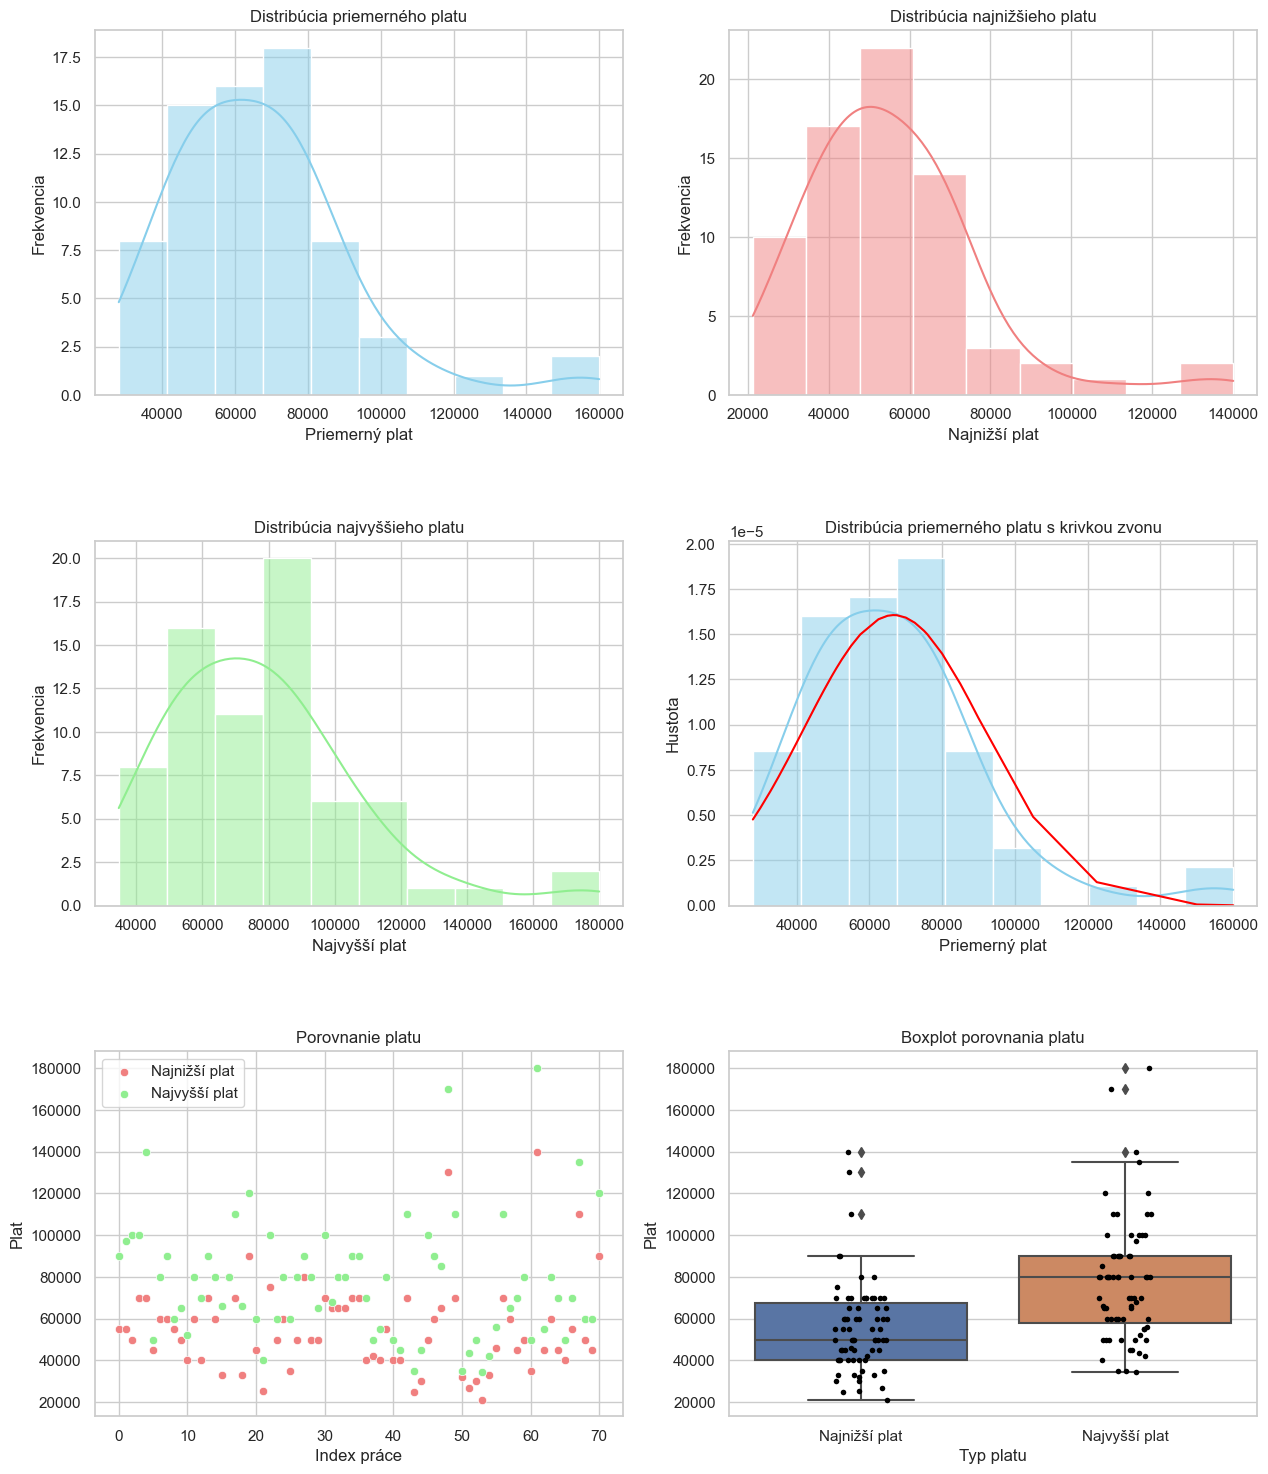

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

#nov√Ω stƒ∫pec pre priemernej hodnoty
platy_df_no_zeros['Priemern√Ω plat'] = platy_df_no_zeros[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat']].mean(axis=1)

#prca s najvy≈°≈°√≠m a najni≈æ≈°√≠m platom
najvyssie_platena_praca = platy_df_no_zeros.loc[platy_df_no_zeros['Najvy≈°≈°√≠ plat'].idxmax()]
najnizsie_platena_praca = platy_df_no_zeros.loc[platy_df_no_zeros['Najni≈æ≈°√≠ plat'].idxmin()]

print(f"\nNajvy≈°≈°ie platen√° pr√°ca:\n{najvyssie_platena_praca}")
print(f"\nNajni≈æ≈°ie platen√° pr√°ca:\n{najnizsie_platena_praca}")

sns.set(style="whitegrid")

#obr√°zok s viacer√Ωmi podgrafmi
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.subplots_adjust(hspace=0.4)

# Graf distrib√∫cie priemern√©ho platu
sns.histplot(platy_df_no_zeros['Priemern√Ω plat'], kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distrib√∫cia priemern√©ho platu')
axes[0, 0].set_xlabel('Priemern√Ω plat')
axes[0, 0].set_ylabel('Frekvencia')

# Graf distrib√∫cie najni≈æ≈°ieho platu
sns.histplot(platy_df_no_zeros['Najni≈æ≈°√≠ plat'], kde=True, color='lightcoral', ax=axes[0, 1])
axes[0, 1].set_title('Distrib√∫cia najni≈æ≈°ieho platu')
axes[0, 1].set_xlabel('Najni≈æ≈°√≠ plat')
axes[0, 1].set_ylabel('Frekvencia')

# Graf distrib√∫cie najvy≈°≈°ieho platu
sns.histplot(platy_df_no_zeros['Najvy≈°≈°√≠ plat'], kde=True, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Distrib√∫cia najvy≈°≈°ieho platu')
axes[1, 0].set_xlabel('Najvy≈°≈°√≠ plat')
axes[1, 0].set_ylabel('Frekvencia')

# Graf zvonovej krivky pre priemern√Ω plat
sns.histplot(platy_df_no_zeros['Priemern√Ω plat'], kde=True, color='skyblue', ax=axes[1, 1], stat='density')
sns.lineplot(x=platy_df_no_zeros['Priemern√Ω plat'], y=norm.pdf(platy_df_no_zeros['Priemern√Ω plat'], platy_df_no_zeros['Priemern√Ω plat'].mean(), platy_df_no_zeros['Priemern√Ω plat'].std()), color='red', ax=axes[1, 1])
axes[1, 1].set_title('Distrib√∫cia priemern√©ho platu s krivkou zvonu')
axes[1, 1].set_xlabel('Priemern√Ω plat')
axes[1, 1].set_ylabel('Hustota')

# Graf porovnania platu
sns.scatterplot(x=platy_df_no_zeros.index, y=platy_df_no_zeros['Najni≈æ≈°√≠ plat'], color='lightcoral', label='Najni≈æ≈°√≠ plat', ax=axes[2, 0])
sns.scatterplot(x=platy_df_no_zeros.index, y=platy_df_no_zeros['Najvy≈°≈°√≠ plat'], color='lightgreen', label='Najvy≈°≈°√≠ plat', ax=axes[2, 0])
axes[2, 0].set_title('Porovnanie platu')
axes[2, 0].set_xlabel('Index pr√°ce')
axes[2, 0].set_ylabel('Plat')
axes[2, 0].legend()

# Graf boxplotu pre porovnanie platu
sns.boxplot(x='variable', y='value', data=pd.melt(platy_df_no_zeros[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat']]), ax=axes[2, 1])
axes[2, 1].set_title('Boxplot porovnania platu')
axes[2, 1].set_xlabel('Typ platu')
axes[2, 1].set_ylabel('Plat')

# kvartily k boxplotu
sns.stripplot(x='variable', y='value', data=pd.melt(platy_df_no_zeros[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat']]), color='black', size=4, jitter=True, ax=axes[2, 1])

# Zobrazenie ≈°tatist√≠k
print("\nInform√°cie o ≈°tatistik√°ch:")
print(platy_df_no_zeros[['Najni≈æ≈°√≠ plat', 'Najvy≈°≈°√≠ plat', 'Priemern√Ω plat']].describe())

plt.show()
